<a href="https://colab.research.google.com/github/OmdenaAI/Bhutan-Mental-Health/blob/ml_nlp/Model_classification_Tsovinar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv("/content/drive/MyDrive/combined_data.csv")

In [ ]:
data = pd.read_csv('/kaggle/input/combined-data-csv/combined_data.csv')

In [6]:
ndata = data.dropna().reset_index(drop=True)  # Reset index here

text = ndata['text']
labels = ndata['mental_state'].values
label_map = {emotion: idx for idx, emotion in enumerate(np.unique(labels))}
num_labels = len(label_map)
y_encoded = np.array([label_map[l] for l in labels])

In [6]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# With this:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels).to(device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from tqdm import tqdm
import torch
MAX_LEN  = 512
def pre_tokenize_headtail(texts, labels, tokenizer, max_len=512):
    input_ids = []
    attention_masks = []
    for text in tqdm(texts):
        tokens = tokenizer.encode(text, add_special_tokens=True)
        if len(tokens) > max_len:
            head = tokens[:max_len//2]
            tail = tokens[-max_len//2:]
            tokens = head + tail
        # Pad or truncate to max_len
        if len(tokens) < max_len:
            tokens = tokens + [tokenizer.pad_token_id] * (max_len - len(tokens))
        else:
            tokens = tokens[:max_len]
        mask = [1 if t != tokenizer.pad_token_id else 0 for t in tokens]
        input_ids.append(tokens)
        attention_masks.append(mask)
    return {
        'input_ids': torch.tensor(input_ids),
        'attention_mask': torch.tensor(attention_masks),
        'labels': torch.tensor(labels)
    }

# Apply to train/val
train_data = pre_tokenize_headtail(X_train.tolist(), y_train, tokenizer, MAX_LEN)
val_data = pre_tokenize_headtail(X_val.tolist(), y_val, tokenizer, MAX_LEN)

100%|██████████| 24649/24649 [01:31<00:00, 270.65it/s]


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [9]:
# Weighted Focal Loss
class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2, weights=None, device='cuda'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weights = weights
        self.device = device

    def forward(self, inputs, targets):
        targets = targets.to(self.device)
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.weights is not None:
            weights = self.weights[targets]
            weighted_loss = focal_loss * weights
            return weighted_loss.mean()
        return focal_loss.mean()

# Initialize loss function
loss_fn = WeightedFocalLoss(alpha=0.5, gamma=3, weights=weights_tensor, device=device)


In [10]:

from torch.optim import AdamW
def get_optimizer_grouped_parameters(model, base_lr=2e-5, lr_decay=0.95):
    # For DistilBERT, there are 6 transformer layers: layer.0 ... layer.5
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = []
    # Classifier head
    optimizer_grouped_parameters.append({
        "params": [p for n, p in model.named_parameters() if "classifier" in n],
        "weight_decay": 0.01,
        "lr": base_lr,
    })
    # Transformer layers (from last to first, higher lr for higher layers)
    for i in range(5, -1, -1):
        lr = base_lr * (lr_decay ** (5 - i))
        optimizer_grouped_parameters.append({
            "params": [p for n, p in model.named_parameters() if f"layer.{i}." in n and not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01,
            "lr": lr,
        })
        optimizer_grouped_parameters.append({
            "params": [p for n, p in model.named_parameters() if f"layer.{i}." in n and any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
            "lr": lr,
        })
    # Embeddings
    optimizer_grouped_parameters.append({
        "params": [p for n, p in model.named_parameters() if "embeddings" in n],
        "weight_decay": 0.01,
        "lr": base_lr * (lr_decay ** 6),
    })
    return optimizer_grouped_parameters

# Usage example:
optimizer_grouped_parameters = get_optimizer_grouped_parameters(model, base_lr=2e-5, lr_decay=0.95)
optimizer = AdamW(optimizer_grouped_parameters, eps=1e-8)

In [11]:
# Replace TensorDataset with this custom dictionary-style dataset
class PrecomputedDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }




In [12]:
# ===== FIXED UNFREEZING STRATEGY =====
def unfreeze_layers(model, current_epoch, freeze_at_epoch=2):
    """Gradually unfreeze layers during training"""
    # Initial freezing - freeze all except classifier and last layer
    if current_epoch == 0:
        print("Initial freezing: Only classifier and last layer are trainable")
        for name, param in model.named_parameters():
            if 'classifier' not in name and 'layer.5' not in name:
                param.requires_grad = False

    # Unfreeze additional layers after certain epochs
    if current_epoch >= freeze_at_epoch:
        print(f"Epoch {current_epoch}: Unfreezing layers 4 and 5")
        for name, param in model.named_parameters():
            if 'layer.4' in name or 'layer.5' in name or 'classifier' in name:
                param.requires_grad = True

    return model
class CustomLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn
        self.label_names = ["labels"]
        self._current_epoch = -1  # Track current epoch internally

    def create_optimizer(self):
        if self.optimizer is None:
            optimizer_grouped_parameters = get_optimizer_grouped_parameters(
                self.model, base_lr=self.args.learning_rate, lr_decay=0.95
            )
            self.optimizer = AdamW(optimizer_grouped_parameters, eps=1e-8)
        return self.optimizer

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

    def train(self, *args, **kwargs):
        self._current_epoch += 1
        if hasattr(self, 'model'):
            self.model = unfreeze_layers(self.model, self._current_epoch)
        return super().train(*args, **kwargs)



In [18]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 1. Pretokenize all data ONCE
all_data = pre_tokenize_headtail(text.tolist(), y_encoded, tokenizer, MAX_LEN)
input_ids_all = all_data['input_ids']
attention_mask_all = all_data['attention_mask']
labels_all = all_data['labels']



100%|██████████| 123244/123244 [08:33<00:00, 239.86it/s]


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy='epoch',  # Corrected from 'eval_strategy'
    save_strategy='epoch',
    fp16=torch.cuda.is_available(),
    logging_dir='./logs',
    report_to='none',
    dataloader_pin_memory=True,
    gradient_accumulation_steps=1,
    ddp_find_unused_parameters=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True
)

# Trainer initialization
trainer = CustomLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        'f1': f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted'),
        'precision': precision_score(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted'),
        'recall': recall_score(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')
    },
    loss_fn=loss_fn
)

# Train & Evaluate
trainer.train()
results = trainer.evaluate()
print("Validation Results:", results)

# Save model and tokenizer
trainer.save_model('./results')
tokenizer.save_pretrained('./results')
save_path = "/content/drive/MyDrive/bert_results_2026"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

Initial freezing: Only classifier and last layer are trainable


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.261600,0.223785,0.734959,0.738957,0.752975,0.734959
2,0.227900,0.203206,0.726155,0.728582,0.762981,0.726155
3,0.171000,0.217306,0.738042,0.738356,0.771100,0.738042
4,0.166100,0.217936,0.755041,0.756133,0.775391,0.755041


Validation Results: {'eval_loss': 0.21793587505817413, 'eval_accuracy': 0.7550407724451296, 'eval_f1': 0.7561329462403492, 'eval_precision': 0.7753913049800638, 'eval_recall': 0.7550407724451296, 'eval_runtime': 172.3906, 'eval_samples_per_second': 142.983, 'eval_steps_per_second': 8.939, 'epoch': 4.0}


('/content/drive/MyDrive/bert_results_2026/tokenizer_config.json',
 '/content/drive/MyDrive/bert_results_2026/special_tokens_map.json',
 '/content/drive/MyDrive/bert_results_2026/vocab.json',
 '/content/drive/MyDrive/bert_results_2026/merges.txt',
 '/content/drive/MyDrive/bert_results_2026/added_tokens.json')

In [11]:

from transformers import RobertaTokenizer, RobertaModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/bert_results_2026"

tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaModel.from_pretrained(model_path).to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/bert_results_2026 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_embeddings_mean_max_chunked(texts, tokenizer, model, device, max_length=512, stride=256):
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    if isinstance(texts, str):
        texts = [texts]
    all_embeddings = []
    hidden_size = getattr(model.config, "dim", None) or getattr(model.config, "hidden_size", 768)
    for text in texts:
        # Use tokenizer's built-in chunking
        inputs = tokenizer(
            text,
            return_tensors="pt",
            max_length=max_length,
            truncation=True,
            padding="max_length",
            stride=stride,
            return_overflowing_tokens=True
        )
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        chunk_embeddings = []
        for i in range(input_ids.size(0)):
            with torch.no_grad():
                outputs = model(input_ids=input_ids[i:i+1], attention_mask=attention_mask[i:i+1])
            last_hidden = outputs.last_hidden_state
            mask = attention_mask[i:i+1].unsqueeze(-1).expand(last_hidden.size()).float()
            mean_pool = torch.sum(last_hidden * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)
            max_pool = torch.max(last_hidden.masked_fill(mask == 0, -1e9), 1)[0]
            pooled = torch.cat([mean_pool, max_pool], dim=1)
            chunk_embeddings.append(pooled.cpu().numpy())
        if chunk_embeddings:
            all_embeddings.append(np.mean(np.vstack(chunk_embeddings), axis=0))
        else:
            all_embeddings.append(np.zeros((hidden_size * 2,)))
    return np.vstack(all_embeddings)

embeddings = get_embeddings_mean_max_chunked(text, tokenizer, model, device)
np.save('/content/drive/MyDrive/roberta_embeddings.npy', embeddings)
pd.DataFrame(embeddings).to_csv('/content/drive/MyDrive/roberta_embeddings.csv', index=False)

In [14]:
embeddings = np.load('/content/drive/MyDrive/roberta_embeddings.npy')


In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(ndata['mental_state'])
from sklearn.feature_extraction.text import TfidfVectorizer

# Limit max_features for memory/speed
tfidf = TfidfVectorizer(max_features=300)
tfidf_features = tfidf.fit_transform(text).toarray()


# Combine with embeddings (after generating them)
X_full = np.hstack([embeddings, tfidf_features])

# Now use X_full instead of embeddings for train/test split and LightGBM
X_train1, X_test1, y_train, y_test = train_test_split(
    X_full, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

In [16]:

from sklearn.preprocessing import StandardScaler
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train1)
X_test = scaler.transform(X_test1)


In [ ]:
import numpy as np
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, log_loss, accuracy_score,
                            precision_score, recall_score, f1_score, confusion_matrix)

# y_train should be your training labels (already encoded as integers)
class_counts = np.bincount(y_train)
total = len(y_train)
num_classes = len(class_counts)

# Compute class weights: inverse frequency
class_weights = {i: total / (num_classes * count) for i, count in enumerate(class_counts)}

# Assign a weight to each sample in y_train
sample_weights = np.array([class_weights[label] for label in y_train])

# When creating the LightGBM Dataset:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train, weight=sample_weights)
test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False)


==================== Fold 1 / 5 ====================
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.263183	train's multi_error: 0.0744163	valid's multi_logloss: 0.631343	valid's multi_error: 0.233478
[100]	train's multi_logloss: 0.160153	train's multi_error: 0.0502626	valid's multi_logloss: 0.56776	valid's multi_error: 0.223052
[150]	train's multi_logloss: 0.113479	train's multi_error: 0.0335141	valid's multi_logloss: 0.547762	valid's multi_error: 0.216317
[200]	train's multi_logloss: 0.086067	train's multi_error: 0.022812	valid's multi_logloss: 0.541065	valid's multi_error: 0.211165
[250]	train's multi_logloss: 0.0678233	train's multi_error: 0.0151033	valid's multi_logloss: 0.540864	valid's multi_error: 0.20938
Early stopping, best iteration is:
[225]	train's multi_logloss: 0.0761175	train's multi_error: 0.0187314	valid's multi_logloss: 0.540428	valid's multi_error: 0.210394
Fold 1 - Accuracy: 0.7896, F1: 0.7907, Loss: 0.5404
              

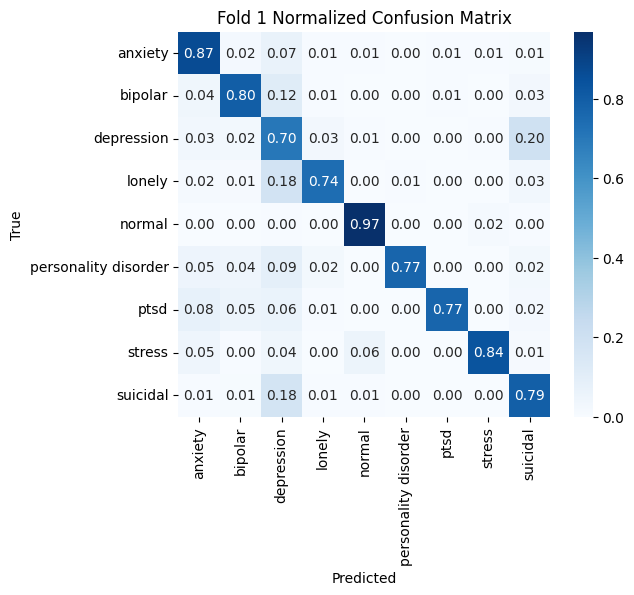


==================== Fold 2 / 5 ====================
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.263199	train's multi_error: 0.0748829	valid's multi_logloss: 0.628739	valid's multi_error: 0.229502
[100]	train's multi_logloss: 0.16084	train's multi_error: 0.0507992	valid's multi_logloss: 0.567627	valid's multi_error: 0.221429
[150]	train's multi_logloss: 0.113602	train's multi_error: 0.033516	valid's multi_logloss: 0.548663	valid's multi_error: 0.21368
[200]	train's multi_logloss: 0.0855781	train's multi_error: 0.0224077	valid's multi_logloss: 0.542731	valid's multi_error: 0.208933
[250]	train's multi_logloss: 0.0671593	train's multi_error: 0.0146093	valid's multi_logloss: 0.542468	valid's multi_error: 0.207351
Early stopping, best iteration is:
[229]	train's multi_logloss: 0.0741515	train's multi_error: 0.0175664	valid's multi_logloss: 0.541333	valid's multi_error: 0.207311
Fold 2 - Accuracy: 0.7927, F1: 0.7936, Loss: 0.5413
             

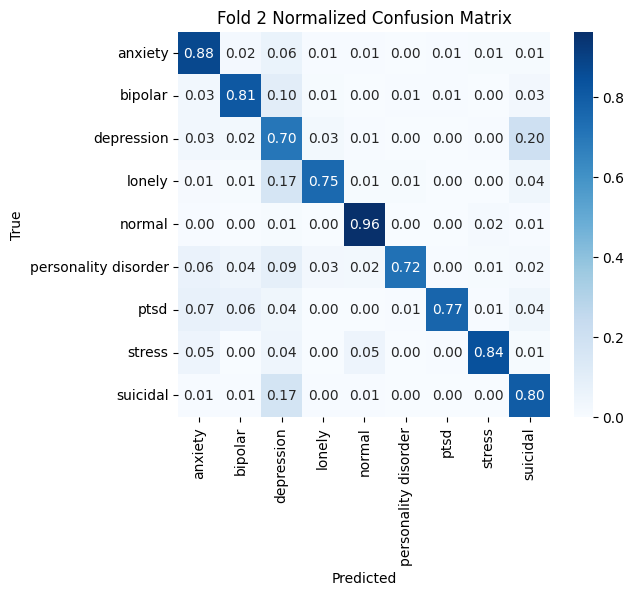


==================== Fold 3 / 5 ====================
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.26385	train's multi_error: 0.075615	valid's multi_logloss: 0.629506	valid's multi_error: 0.233397
[100]	train's multi_logloss: 0.160844	train's multi_error: 0.0504522	valid's multi_logloss: 0.565807	valid's multi_error: 0.222768
[150]	train's multi_logloss: 0.114069	train's multi_error: 0.0335054	valid's multi_logloss: 0.548771	valid's multi_error: 0.215871
[200]	train's multi_logloss: 0.0860298	train's multi_error: 0.0227701	valid's multi_logloss: 0.542492	valid's multi_error: 0.21226
[250]	train's multi_logloss: 0.067747	train's multi_error: 0.015106	valid's multi_logloss: 0.543811	valid's multi_error: 0.209501
Early stopping, best iteration is:
[208]	train's multi_logloss: 0.082621	train's multi_error: 0.021268	valid's multi_logloss: 0.542313	valid's multi_error: 0.211976
Fold 3 - Accuracy: 0.7880, F1: 0.7890, Loss: 0.5423
                 

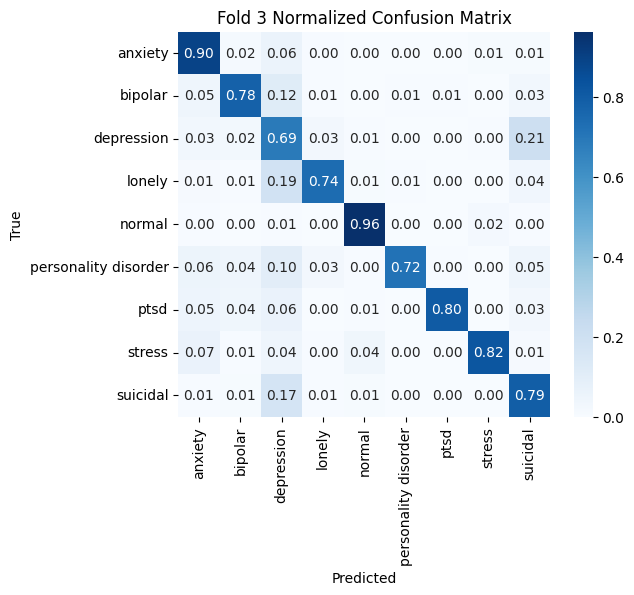


==================== Fold 4 / 5 ====================
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.261732	train's multi_error: 0.0740265	valid's multi_logloss: 0.640854	valid's multi_error: 0.238346
[100]	train's multi_logloss: 0.158293	train's multi_error: 0.0498757	valid's multi_logloss: 0.578182	valid's multi_error: 0.226784
[150]	train's multi_logloss: 0.111992	train's multi_error: 0.0331555	valid's multi_logloss: 0.560532	valid's multi_error: 0.220009
[200]	train's multi_logloss: 0.0844805	train's multi_error: 0.0221912	valid's multi_logloss: 0.556095	valid's multi_error: 0.214613
[250]	train's multi_logloss: 0.0662695	train's multi_error: 0.0144279	valid's multi_logloss: 0.556628	valid's multi_error: 0.211692
Early stopping, best iteration is:
[219]	train's multi_logloss: 0.076634	train's multi_error: 0.0188729	valid's multi_logloss: 0.555543	valid's multi_error: 0.213072
Fold 4 - Accuracy: 0.7869, F1: 0.7880, Loss: 0.5555
           

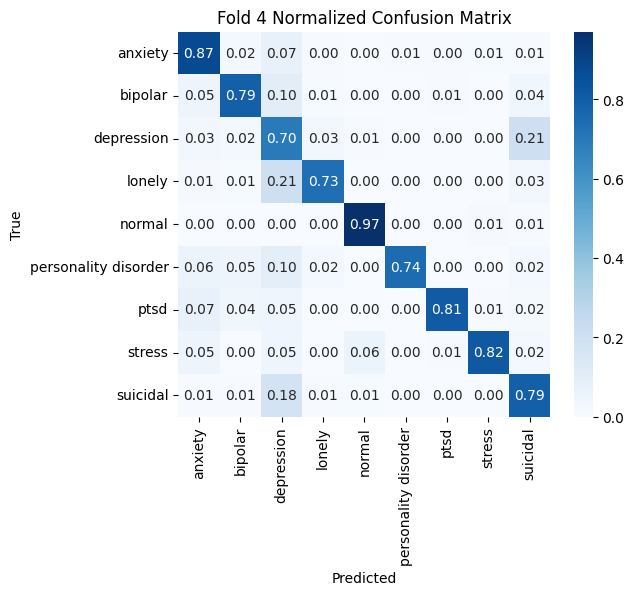


==================== Fold 5 / 5 ====================
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.263119	train's multi_error: 0.074536	valid's multi_logloss: 0.634349	valid's multi_error: 0.232879
[100]	train's multi_logloss: 0.161219	train's multi_error: 0.0503795	valid's multi_logloss: 0.570957	valid's multi_error: 0.223223
[150]	train's multi_logloss: 0.114148	train's multi_error: 0.0338057	valid's multi_logloss: 0.551642	valid's multi_error: 0.217137
[200]	train's multi_logloss: 0.0864699	train's multi_error: 0.0228746	valid's multi_logloss: 0.54638	valid's multi_error: 0.214216
[250]	train's multi_logloss: 0.0678049	train's multi_error: 0.0149654	valid's multi_logloss: 0.546224	valid's multi_error: 0.210849
Early stopping, best iteration is:
[245]	train's multi_logloss: 0.069307	train's multi_error: 0.015587	valid's multi_logloss: 0.545762	valid's multi_error: 0.211133
Fold 5 - Accuracy: 0.7889, F1: 0.7900, Loss: 0.5458
              

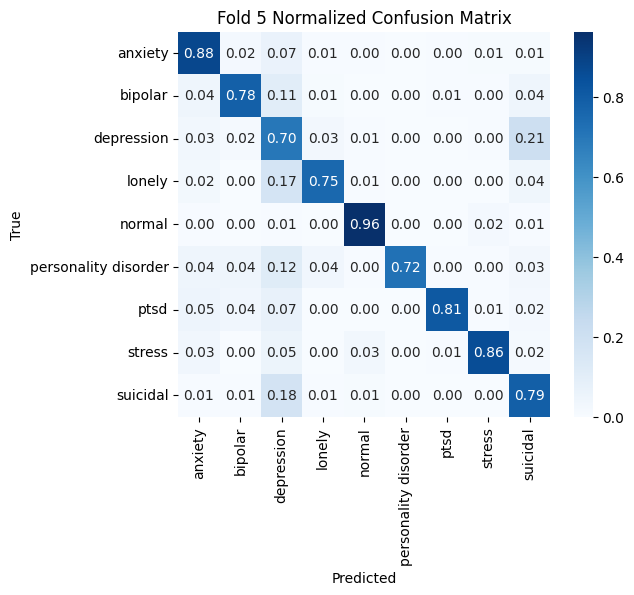


Average Cross-Validation Metrics:
Accuracy  : 0.7892 ± 0.0019
Precision : 0.7990 ± 0.0018
Recall    : 0.7892 ± 0.0019
F1        : 0.7902 ± 0.0019
Loss      : 0.5451 ± 0.0055


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report, confusion_matrix
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store metrics for each fold
fold_metrics = []
# LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'metric': ['multi_logloss', 'multi_error'],  # Track both loss and error
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 100,  # Increased capacity
    'max_depth': 8,
    'min_child_samples': 20,
    'reg_alpha': 0.8,
    'reg_lambda': 0.5,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'random_state': 42,
    'verbosity': -1 ,
    'device': 'gpu'

}


for fold, (train_idx, val_idx) in enumerate(skf.split(X_full, labels_encoded)):
    print(f"\n{'='*20} Fold {fold+1} / {n_splits} {'='*20}")
    X_train, X_val = X_full[train_idx], X_full[val_idx]
    y_train, y_val = labels_encoded[train_idx], labels_encoded[val_idx]

    # Compute class weights for this fold
    class_counts = np.bincount(y_train)
    total = sum(class_counts)
    class_weights = [total / (len(class_counts) * count) for count in class_counts]
    weights = np.array([class_weights[x] for x in y_train])

    # LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train, weight=weights)
    val_data = lgb.Dataset(X_val, label=y_val, free_raw_data=False)

    # LightGBM parameters (reuse your params dict)
    evals_result = {}
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),
            lgb.record_evaluation(evals_result),
            lgb.log_evaluation(period=50)
        ]
    )

    # Predictions
    y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    val_loss = log_loss(y_val, y_pred_proba)

    print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Loss: {val_loss:.4f}")

    # Optionally print classification report and confusion matrix
    print(classification_report(y_val, y_pred, target_names=le.classes_, digits=4))
    cm = confusion_matrix(y_val, y_pred, normalize='true')
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Fold {fold+1} Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Store metrics
    fold_metrics.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'loss': val_loss
    })

# Print average metrics across folds
print("\n" + "="*30)
print("Average Cross-Validation Metrics:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'loss']:
    values = [fm[metric] for fm in fold_metrics]
    print(f"{metric.capitalize():<10}: {np.mean(values):.4f} ± {np.std(values):.4f}")
print("="*30)

In [2]:
import os

folder_path = r'C:\Users\ADMIN\Desktop\Github_upload\mental_health'
print("Files in directory:", os.listdir(folder_path))

Files in directory: ['6epeochs.ipynb', 'focal_lightGM (1).ipynb', 'focal_lightGM.ipynb', 'longformer-lightgm.ipynb', 'roberta_end_end_tried.ipynb']
